In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import TweetTokenizer
from sklearn import linear_model, svm
from sklearn.metrics import recall_score, precision_score, f1_score,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split    
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import FeatureUnion
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Data set

In [2]:
df =pd.read_csv('https://raw.githubusercontent.com/EdwinPuertas/MachineLearning-ISCO-A14A/main/data/tweets_politica.csv',sep=";")
df.head(10)

,cuenta,partido,timestamp,tweet
0,a34133350b0605cb24081843f63176ca,psoe,13639734920,@vesteve3 @manubenas @ccoo_rm @desobediencia_ ...
1,a34133350b0605cb24081843f63176ca,psoe,13640610350,"“@kirovast: @Hugo_Moran muy fan de la ""radical..."
2,a34133350b0605cb24081843f63176ca,psoe,13641168040,@ALTAS_PRESIONES Nuevos dueños para las renova...
3,a34133350b0605cb24081843f63176ca,psoe,13641209670,@jumanjisolar @solartradex @josea_dolera El di...
4,a34133350b0605cb24081843f63176ca,psoe,13641526920,“@cesarnayu: https://t.co/J4OTXj1x7w … Por fav...
5,a34133350b0605cb24081843f63176ca,psoe,13641538760,“@iAgua: http://t.co/6yMSNcV1UA” (El Gobierno ...
6,a34133350b0605cb24081843f63176ca,psoe,13641548230,"""Cospedal: las crisis ya no afectan a España. ..."
7,a34133350b0605cb24081843f63176ca,psoe,13642018620,“@ventonoso: España importa ya energía de Port...
8,a34133350b0605cb24081843f63176ca,psoe,13642070630,@elsoldemerix El Gobierno Andaluz presenta rec...
9,a34133350b0605cb24081843f63176ca,psoe,13642109030,“@mjocaballero: Maria Dolores de Cospedal dema...


# Descripción del data set

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130029 entries, 0 to 130028
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   cuenta     130029 non-null  object
 1   partido    130029 non-null  object
 2   timestamp  130029 non-null  int64 
 3   tweet      130029 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.0+ MB


In [4]:
partido_politico = df.groupby("partido", as_index=False)['tweet'].count()
partido_politico.head(10)

,partido,tweet
0,ciudadanos,23552
1,podemos,24889
2,pp,26200
3,psoe,28882
4,vox,26506


C:\Users\Lenovo\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


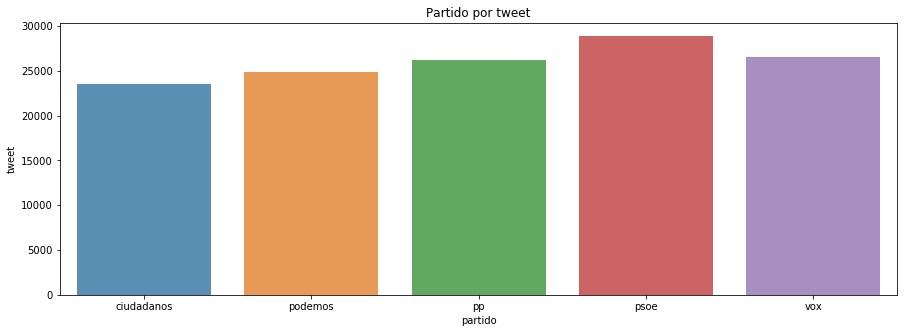

In [5]:
plt.figure(figsize=(15,5))
sns.barplot(partido_politico['partido'].values, partido_politico['tweet'].values, alpha=0.8)
plt.title('Partido por tweet')
plt.ylabel('tweet', fontsize=10)
plt.xlabel('partido', fontsize=10)
plt.show()

# Pregunta e hipotesis

Para entrenar el modelo para que sea capaz de clasificar los tweets de manera correcta, primero debemos responder la pregunta ¿Cómo podemos determinar a que partido politico pertenece el usuario de tweet?  
Se cree que es posible determinarlo a partir de las palabras que este usa, y ver que tan frecuente menciona o usa palabras relacionadas con cada partido politico, pero esto no es suficiente, pues un usuario puede mencionar a un partido politico y hablar cosas malas de el, por ello tambien se deben estudiar las palabras cercanas.

# Extracción de caracteristicas

In [6]:
dt={'Tweet':df['tweet'].values,'Partido':df['partido'].values}
dts=pd.DataFrame(data=dt)
dts

,Tweet,Partido
0,@vesteve3 @manubenas @ccoo_rm @desobediencia_ ...,psoe
1,"“@kirovast: @Hugo_Moran muy fan de la ""radical...",psoe
2,@ALTAS_PRESIONES Nuevos dueños para las renova...,psoe
3,@jumanjisolar @solartradex @josea_dolera El di...,psoe
4,“@cesarnayu: https://t.co/J4OTXj1x7w … Por fav...,psoe
...,...,...
130024,"Qué maravilla, visitar #LaRioja en #vendimia🍇,...",psoe
130025,"“Querido Pablo, nos complace tu voluntad de re...",pp
130026,"Quiero reivindicar la buena política, la de fr...",psoe
130027,🙋🏻‍♀️El pasado viernes se cumplió el aniversar...,psoe


In [7]:
dts['Partido']=dts['Partido'].replace('psoe',0)
dts['Partido']=dts['Partido'].replace('pp',1)
dts['Partido']=dts['Partido'].replace('vox',2)
dts['Partido']=dts['Partido'].replace('podemos',3)
dts['Partido']=dts['Partido'].replace('ciudadanos',4)

In [8]:
dts

,Tweet,Partido
0,@vesteve3 @manubenas @ccoo_rm @desobediencia_ ...,0
1,"“@kirovast: @Hugo_Moran muy fan de la ""radical...",0
2,@ALTAS_PRESIONES Nuevos dueños para las renova...,0
3,@jumanjisolar @solartradex @josea_dolera El di...,0
4,“@cesarnayu: https://t.co/J4OTXj1x7w … Por fav...,0
...,...,...
130024,"Qué maravilla, visitar #LaRioja en #vendimia🍇,...",0
130025,"“Querido Pablo, nos complace tu voluntad de re...",1
130026,"Quiero reivindicar la buena política, la de fr...",0
130027,🙋🏻‍♀️El pasado viernes se cumplió el aniversar...,0


# Conjunto de entranamiento y prueba

In [9]:
x= dts['Tweet'].values
y=dts['Partido'].values


In [10]:
#función que divide
def separador(lista1,lista2):
    train1=[]
    train2=[]
    test1=[]
    test2=[]
    a=0
    b=0
    c=0
    d=0
    e=0
    k=0
    f=round(len(lista1)*0.2)-6
    for x in range(len(lista1)):
        if k<f and a<f/5 and lista1[x]==0:
            test1.append(lista1[x])
            test2.append(lista2[x])
            a+=1
            k+=1
        elif k<f and b<f/5 and lista1[x]==1:
            test1.append(lista1[x])
            test2.append(lista2[x])
            b+=1
            k+=1
        elif k<f and c<f/5 and lista1[x]==2:
            test1.append(lista1[x])
            test2.append(lista2[x])
            c+=1
            k+=1
        elif k<f and d<f/5 and lista1[x]==3:
            test1.append(lista1[x])
            test2.append(lista2[x])
            d+=1
            k+=1
        elif k<f and e<f/5 and lista1[x]==4:
            test1.append(lista1[x])
            test2.append(lista2[x])
            e+=1
            k+=1
        elif k>f or (a>=f/5 and lista1[x]==0) or (b>=f/5 and lista1[x]==1) or (c>=f/5 and lista1[x]==2) or (d>=f/5 and lista1[x]==3) or (e>=f/5 and lista1[x]==4):
            train1.append(lista1[x])
            train2.append(lista2[x])
    return(train1,train2,test1,test2)

In [11]:
y_train,x_train,y_test,x_test=separador(y,x)

In [12]:
len(x_train),len(x_test),len(y_train),len(y_test)

(104029, 26000, 104029, 26000)

In [13]:
train={'tweet':x_train,'partido':y_train}
trainpd=pd.DataFrame(data=train)
trainpd

,tweet,partido
0,El Gobierno trabaja en coordinación con las CC...,0
1,@BaloncestoESP ¡España está con vosotros!Prepa...,0
2,⚖️ Un Gobierno comprometido con la justicia so...,0
3,“El que hace trampa es porque no tiene coraje ...,0
4,Buenos días! Elton John - Rocket Man (Official...,0
...,...,...
104024,"Qué maravilla, visitar #LaRioja en #vendimia🍇,...",0
104025,"“Querido Pablo, nos complace tu voluntad de re...",1
104026,"Quiero reivindicar la buena política, la de fr...",0
104027,🙋🏻‍♀️El pasado viernes se cumplió el aniversar...,0


In [14]:
test={'tweet':x_test,'partido':y_test}
testpd=pd.DataFrame(data=test)
testpd

,tweet,partido
0,@vesteve3 @manubenas @ccoo_rm @desobediencia_ ...,0
1,"“@kirovast: @Hugo_Moran muy fan de la ""radical...",0
2,@ALTAS_PRESIONES Nuevos dueños para las renova...,0
3,@jumanjisolar @solartradex @josea_dolera El di...,0
4,“@cesarnayu: https://t.co/J4OTXj1x7w … Por fav...,0
...,...,...
25995,😂😂 Debe ser duro para la izquierda encontrarse...,2
25996,“Lo que de verdad une a la izquierda y al naci...,2
25997,Llama centro-izquierda a ERC y Podemos....y ul...,2
25998,El Parlamento Europeo presiona a #Cuba para lo...,2


In [15]:
print('**Sample test:', sorted(Counter(y_test).items()))

**Sample test: [(0, 5200), (1, 5200), (2, 5200), (3, 5200), (4, 5200)]


In [16]:
print('**Sample train:', sorted(Counter(y_train).items()))

**Sample train: [(0, 23682), (1, 21000), (2, 21306), (3, 19689), (4, 18352)]


In [17]:
bow = CountVectorizer(ngram_range=(1, 1))
bong = CountVectorizer(analyzer='word', ngram_range=(2, 2))

# Union

In [18]:
Union = FeatureUnion([
    ('bow_vector', bow),
    ('bong_vector', bong)
])

In [19]:
Union.fit(x_train)

FeatureUnion(transformer_list=[('bow_vector', CountVectorizer()),
                               ('bong_vector',
                                CountVectorizer(ngram_range=(2, 2)))])

In [20]:
x_train = Union.transform(x_train)

In [21]:
x_test = Union.transform(x_test)

In [22]:
ros = RandomOverSampler(random_state=0)
x_train, y_train = ros.fit_resample(x_train, y_train)

In [23]:
print('**OverSample train:', sorted(Counter(y_train).items()))

**OverSample train: [(0, 23682), (1, 23682), (2, 23682), (3, 23682), (4, 23682)]


# Entrenamiento con Softmax_Function

In [24]:
sreg=linear_model.LogisticRegression(multi_class="multinomial",solver="lbfgs",C=10)
sreg.fit(x_train,y_train)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10, multi_class='multinomial')

In [25]:
y_prob=sreg.predict(x_test)

# Metricas

In [26]:
matriz=confusion_matrix(y_test,y_prob)


In [27]:
print("\t\t\tMatriz de confusion")
print("\n             0                1               2            3              4")
print("\n0          ",matriz[0][0],"           ",matriz[0][1],"          ",matriz[0][2],"          ",matriz[0][3],"          ",matriz[0][4])
print("\n1          ",matriz[1][0],"           ",matriz[1][1],"          ",matriz[1][2],"          ",matriz[1][3],"          ",matriz[1][4])
print("\n2          ",matriz[2][0],"           ",matriz[2][1],"          ",matriz[2][2],"          ",matriz[2][3],"          ",matriz[2][4])
print("\n3          ",matriz[3][0],"           ",matriz[3][1],"          ",matriz[3][2],"          ",matriz[3][3],"          ",matriz[3][4])
print("\n4          ",matriz[4][0],"           ",matriz[4][1],"          ",matriz[4][2],"          ",matriz[4][3],"          ",matriz[4][4])

			Matriz de confusion

             0                1               2            3              4

0           3754             323            366            444            313

1           441             3694            388            152            525

2           370             335            3870            236            389

3           546             280            431            3583            360

4           369             534            723            228            3346


In [28]:
print('Accuracy softmax: ', accuracy_score(y_prob,y_test))
print('Recall_score softmas: ', recall_score(y_prob,y_test,average="macro"))
print('Precision_score softmax: ', precision_score(y_prob,y_test,average="weighted"))
print('Puntuación F1 softmax: ', f1_score(y_prob,y_test,average="micro"))

Accuracy softmax:  0.7018076923076924
Recall_score softmas:  0.7039733682943525
Precision_score softmax:  0.703828927514793
Puntuación F1 softmax:  0.7018076923076924


# SVM

In [29]:
ys_train,xs_train,ys_test,xs_test=separador(y,x)

In [30]:
xs_train = Union.transform(xs_train)
xs_test = Union.transform(xs_test)

In [31]:
ros = RandomOverSampler(random_state=0)
xs_train, ys_train = ros.fit_resample(xs_train, ys_train)

In [32]:
from sklearn import preprocessing 
xs_train = preprocessing.scale(xs_train,with_mean=False) 
xs_test = preprocessing.scale(xs_test,with_mean=False)

In [ ]:
xs_train.toarray()

In [33]:
clf = svm.SVC(kernel='poly', degree=3, C=1,max_iter=10,gamma='auto').fit(xs_train, ys_train)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [35]:
ys_prob = clf.predict(xs_test)

In [38]:
matriz=confusion_matrix(ys_test,ys_prob)

In [39]:
print("\t\t\tMatriz de confusion")
print("\n             0                1               2            3              4")
print("\n0          ",matriz[0][0],"           ",matriz[0][1],"          ",matriz[0][2],"          ",matriz[0][3],"          ",matriz[0][4])
print("\n1          ",matriz[1][0],"           ",matriz[1][1],"          ",matriz[1][2],"          ",matriz[1][3],"          ",matriz[1][4])
print("\n2          ",matriz[2][0],"           ",matriz[2][1],"          ",matriz[2][2],"          ",matriz[2][3],"          ",matriz[2][4])
print("\n3          ",matriz[3][0],"           ",matriz[3][1],"          ",matriz[3][2],"          ",matriz[3][3],"          ",matriz[3][4])
print("\n4          ",matriz[4][0],"           ",matriz[4][1],"          ",matriz[4][2],"          ",matriz[4][3],"          ",matriz[4][4])

			Matriz de confusion

             0                1               2            3              4

0           0             0            0            0            5200

1           0             0            0            0            5200

2           0             0            0            0            5200

3           0             0            0            0            5200

4           0             0            0            0            5200


In [40]:
print('Accuracy softmax: ', accuracy_score(ys_prob,ys_test))
print('Recall_score softmas: ', recall_score(ys_prob,ys_test,average="macro"))
print('Precision_score softmax: ', precision_score(ys_prob,ys_test,average="weighted"))
print('Puntuación F1 softmax: ', f1_score(ys_prob,ys_test,average="micro"))

Accuracy softmax:  0.2
Recall_score softmas:  0.04
Precision_score softmax:  1.0
Puntuación F1 softmax:  0.20000000000000004


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Comparación de resultados

Podemos observar por las metricas empleadas, que el modelo softmax es mucho más efectivo que el support vector machine, esto se debe a que svm tiene problemas cuando los datos empleados son muy grandes.